# Math 8803 HW1

## Problem 1 - Connor-Stevens Model


The main differential equation for the Connor-Stevens Model is:

$$I(t) = C (\frac{dV}{dt}) + g_{L}(V - E_{L}) + g_{Na}(V - E_{Na}) + g_{K}(V - E_{K}) + g_{A}(V - E_{K})$$

$$\frac{dV}{dt} = \frac{g_{L}(V - E_{L}) + g_{Na}(V - E_{Na}) + g_{K}(V - E_{K}) + g_{A}(V - E_{K}) - I(t)}{C}$$


#### Explanation of Parameters:

1. $ C (\frac{dV}{dt}) $ - We can think of the membrane as a capacitor and $V$ represents the voltage across the membrane. $C$ is capacitance or $C = \frac{q}{u} = \frac{q}{V}$ where $q$ is a charge and $v$ reprecents the voltage across a capacitor. Thus, $ C (\frac{dV}{dt}) $ is the charging current $I_{c}(t)$ that is applied on the membrane.

2. $E_{Na}$ - Battery Voltage for Sodium

3. $E_{K}$ - Battery Voltage for Potassium

4. $E_{L}$ - Battery Voltage for Unspecific Third Channel

5. $g_{Na} = \overline{g}_{Na} m^{3}h$ - Sodium Conductance. Here $\overline{g}_{Na}$ is a normalization constant, $m$ describes the activation/opening of the and $h$ describes the inactivation/blocking of the $Na^{+}$ channels.  

6. $g_{K} = \overline{g}_{k} n^{4}$ - Delayed Potassium Conductance, where $\overline{g}_{k}$ is a normalization constant and $n$ controls the $K^{+}$ gates. 

7. $g_{A} = \overline{g}_{A} A^{3}B$ - Transient Potassium Conductance, where $\overline{g}_{A}$ is a normalization factor, $A$ is an activation term, and $B$ is an inactivation term. 

8. $g_{L}$ - Leaky Battery Conductance

9. $V$ - Voltage across the cell membrane


In [14]:
import numpy as np 
from scipy.integrate import solve_ivp, odeint
from math import exp, pow
import matplotlib.pyplot as plt

In [15]:
# Rate functions for m 
def alpha_m(V):
	# potential numerical instability
	x = -(V + 29.7)
	y = 10.0
	return (0.38 * x) / (np.exp(x/y) - 1.0)

def beta_m(V):
	return 15.2 * np.exp(-0.0556 * (V + 54.7))

def m_inf(V):
	return alpha_m(V) / (alpha_m(V) + beta_m(V))

def tau_m(V):
	return pow(10, -3) * (alpha_m(V) + beta_m(V))

# Rate functions for h
def alpha_h(V):
	return 0.266 * np.exp(-0.05 * (V + 48))

def beta_h(V):
	return 3.8 / (1 + np.exp(-0.1 * (V + 18)))

def h_inf(V):
	return (alpha_h(V)) / (alpha_h(V) + beta_h(V))

def tau_h(V):
	return pow(10, -3) * (alpha_h(V) + beta_h(V))

# Rate functions for n
def alpha_n(V):
	x = -(V + 45.7)
	y = 10.0
	return (0.02 * x) / (np.exp(x / y) - 1.0)

def beta_n(V):
	return 0.25 * np.exp(-0.0125 * (V + 55.7))

def n_inf(V):
	return alpha_n(V) / (alpha_n(V) + beta_n(V))

def tau_n(V):
	return pow(10, -3) * (alpha_n(V) + beta_n(V))

# Rate functions for a
def a_inf(V):
	num = 0.0761 * np.exp(0.0314 * (V + 94.22))
	den = 1 + np.exp(0.0346 * (V + 1.17))
	return pow(num / den, 1 / 3.0)

def tau_a(V):
	den = 1 + np.exp(0.0497 * (V + 55.96))
	return 0.3632 + (1.158 / den)

# Rate functiosn for b
def b_inf(V):
	term = (1 / (1 + np.exp(0.0688 * (V + 53.3))))
	return pow(term, 4)

def tau_b(V):
	den = 1 + np.exp(0.0624 * (V + 50))
	return 1.24 + (2.678 / den) 


#### Define constants

1/cm^2 to 1/mm^2 Divide by 100

1/mm^2 to 1/cm^2 Multiply by 100

In [16]:
V0 = -68 # -68 mV

# All in mmho /cm^2
g_bar_na = 120 
g_bar_k = 20
g_bar_a = 47.7

# All in mV
E_na = 55
E_k = -72
E_l = -17

# Capacitance and Leaky Conductance
Cm = 1 # microFarad/cm^2
g_l = 0.3 # mmho/cm^2

x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), a_inf(V0), b_inf(V0)]
T = np.linspace(0, 150, 1500)

In [17]:
def ConnorStevens(x, t):
	V = x[0]
	m = x[1]
	h = x[2]
	n = x[3]
	a = x[4]
	b = x[5]

	I = 0
	if 50 < t < 100:
		I = 10

	dmdt = alpha_m(V) * (1 - x[1]) - (beta_m(V) * x[1])

	dhdt = alpha_h(V) * (1 - x[2]) - (beta_h(V) * x[2])

	dndt = alpha_n(V) * (1 - x[3]) - (beta_n(V) * x[3])

	dadt = (a_inf(V) - x[4]) / tau_a(V)

	dbdt = (b_inf(V) - x[5]) / tau_b(V)

	I_l = -g_l * (V - E_l)
	I_na = -g_bar_na * (pow(m, 3) * h) * (V - E_na)
	I_k = -g_bar_k * (pow(n, 4)) * (V - E_k)
	I_a = -g_bar_a * (pow(a, 3) * b) * (V - E_k)

	dvdt = (I + I_l + I_na + I_k + I_a) / Cm

	return [dvdt, dmdt, dhdt, dndt, dadt, dbdt]

In [18]:
x = odeint(ConnorStevens, x0, T)

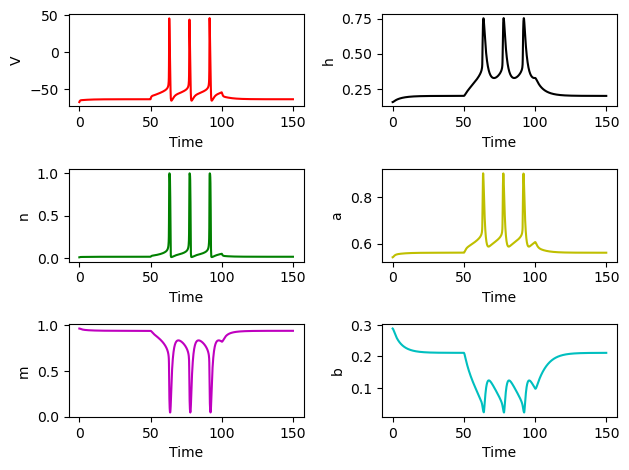

In [19]:
volt = x[:, 0]
n_part = x[:, 1]
m_part = x[:, 2]
h_part = x[:, 3]
a = x[:, 4]
b = x[:, 5]

fig, ax = plt.subplots(3, 2)
ax[0, 0].plot(T, volt, 'r')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("V")

ax[1, 0].plot(T, n_part, 'g')
ax[1, 0].set_xlabel("Time")
ax[1, 0].set_ylabel("n")

ax[2, 0].plot(T, m_part, 'm')
ax[2, 0].set_xlabel("Time")
ax[2, 0].set_ylabel("m")

ax[0, 1].plot(T, h_part, 'k')
ax[0, 1].set_xlabel("Time")
ax[0, 1].set_ylabel("h")

ax[1, 1].plot(T, a, 'y')
ax[1, 1].set_xlabel("Time")
ax[1, 1].set_ylabel("a")

ax[2, 1].plot(T, b, 'c')
ax[2, 1].set_xlabel("Time")
ax[2, 1].set_ylabel("b")

plt.tight_layout()
plt.show()